# Setup

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K

from tqdm import tqdm
from faker import Faker
from babel.dates import format_date
import random

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load helper functions
import sys
sys.path.append('.')
from nmt_utils import *

In [3]:
def softmax(x, axis=1):
    """
    Softmax activation function
    
    Arguments:
        --x : tensor
        --axis: integer, axis along which the softmax normalization is applied
    
    Returns:
    tensor, output of softmax transformation
    
    Raises:
    ValueError: in case `dim(x) == 1`
    """
    ndim = K.ndim(x)
    if ndim == 2:
        return K.softmax(x)
    elif ndim > 2:
        e = K.exp(x - K.max(x, axis=axis, keepdims=True))
        s = K.sum(e, axis=axis, keepdims=True)
        return e / s
    else:
        raise ValueError('Cannot apply softmax to a tensor that is 1D')

# Data
- `dataset`: a list of tuples of (human readable date, machine readable date).
- `human_vocab`: a python dictionary mapping all characters used in the human readable dates to an integer-valued index.
- `machine_vocab`: a python dictionary mapping all characters used in machine readable dates to an integer-valued index. 
    - **Note**: These indices are not necessarily consistent with `human_vocab`. 
- `inv_machine_vocab`: the inverse dictionary of `machine_vocab`, mapping from indices back to characters. 

## Load data

In [4]:
m = 10000
dataset, human_vocab, machine_vocab, inv_machine_vocab = load_dataset(m)

100%|██████████| 10000/10000 [01:25<00:00, 116.53it/s]


- Overview

In [5]:
dataset[:10]

[('9 may 1998', '1998-05-09'),
 ('10.11.19', '2019-11-10'),
 ('9/10/70', '1970-09-10'),
 ('saturday april 28 1990', '1990-04-28'),
 ('thursday january 26 1995', '1995-01-26'),
 ('monday march 7 1983', '1983-03-07'),
 ('sunday may 22 1988', '1988-05-22'),
 ('08 jul 2008', '2008-07-08'),
 ('8 sep 1999', '1999-09-08'),
 ('thursday january 1 1981', '1981-01-01')]

## Preprocess
- map the raw text data into the index values. 
    - set Tx=30 
        - We assume Tx is the maximum length of the human readable date.
        - If input is longer than Tx: truncate it; if input is shorter than Tx: pad it
    - set Ty=10
        - "YYYY-MM-DD" is 10 characters long.
- processed data
    - `X`: a processed version of the human readable dates in the training set
        - Each character in X is replaced by an index (integer) mapped to the character using `human_vocab`
        - Each date is padded to ensure a length of $T_x$ using a special character (< pad >)
        - shape = (m, Tx), where m is the number of training examples in a batch
    - `y`: a processed version of the machine readable dates in the training set
        - Each character is replaced by the index (integer) it is mapped to in `machine_vocab` 
        - shape = (m, Ty)
    - `X_1h`: one-hot version of X
        - Each index in X_1h is converted to the one-hot representation
        - shape = (m, Tx, len(human_vocab))
    - `y_1h`: one-hot version of Y
        - Each index in y_1h is converted to the one-hot representation
        - shape = (m, Tx, len(machine_vocab)) 
        - len(machine_vocab) = 11 since there are 10 numeric digits (0 to 9) and the `-` symbol

In [6]:
Tx = 30
Ty = 10

X, y, X_1h, y_1h = preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty)

print("X.shape:", X.shape)
print("y.shape:", y.shape)
print("X_1h.shape:", X_1h.shape)
print("y_1h.shape:", y_1h.shape)

X.shape: (10000, 30)
y.shape: (10000, 10)
X_1h.shape: (10000, 30, 37)
y_1h.shape: (10000, 10, 11)


# Neural Machine Translation with Attention
## Attention mechanism
- One-step attention function
    - compute the attention weights/variables $\alpha^{\langle t, t' \rangle}$
    - use $\alpha^{\langle t, t' \rangle}$ to compute context variable $context^{\langle t \rangle}$ for each time-step as the input of the post-attention LSTM networks

## Pre-attention and Post-attention LSTMs
- There are two separate LSTMs in the model: pre-attention and post-attention LSTMs
- Pre-attention Bi-LSTM:
    - the pre-attention Bi-LSTMs comes before the attention mechanism 
    - the pre-attention Bi-LSTMs goes through $T_x$ time-steps
    - Inputs: $x^{\langle t' \rangle}$
    - Outputs: $a^{\langle t' \rangle} = [\overrightarrow{a}^{\langle t' \rangle}, \overleftarrow{a}^{\langle t' \rangle}]$, concatenation of the hidden states of both forward-direction and backward-direction
- Post-attention LSTM:
    - the post-attention LSTMs comes after the attention mechanism
    - the post-attention LSTMs goes through $T_y$ time-steps
    - the post-attention LSTMs passes the hidden state $s^{\langle t \rangle}$ and cell state $c^{\langle t \rangle}$
    - Inputs: $context^{\langle t \rangle}$, which is determined by $a^{\langle t' \rangle}$ and $s^{\langle t-1 \rangle}$
    - Outputs: $y^{\langle t \rangle}$
- Note
    - in this model, the post-attention LSTM at time $t$ does not take the previous time step's prediction $y^{\langle t-1 \rangle}$ as input
    - the post-attention LSTM at time 't' only takes the hidden state $s^{\langle t \rangle}$ and cell state $c^{\langle t\rangle}$ as input 
    - we have designed the model this way because unlike language generation (where adjacent characters are highly correlated) there isn't as strong a dependency between the previous character and the next character in a YYYY-MM-DD date

## Compute "energies" $e^{\langle t, t' \rangle}$
- "energies" variable $e^{\langle t, t' \rangle}$ is computed as a function of $s^{\langle t-1 \rangle}$ and $a^{\langle t' \rangle}$
    - $s^{\langle t-1 \rangle}$ is the hidden state of the post-attention LSTM
    - $a^{\langle t' \rangle}$ is the hidden state of the pre-attention LSTM
- $s^{\langle t \rangle}$ and $a^{\langle t \rangle}$ are fed into a simple neural network, which learns the function to output $e^{\langle t, t' \rangle}$
- $e^{\langle t, t' \rangle}$ is then used when computing the attention $\alpha^{\langle t, t' \rangle}$ that $y^{\langle t \rangle}$ should pay to $a^{\langle t' \rangle}$ (i.e. $x^{\langle t' \rangle}$)

**one_step_attention()**
- since the `model()` will call the layers in `one_step_attention()` Ty times, it's important that all Ty copies have the same weights

In [7]:
# Define shared layers as global variables
## RepeatVector()
repeator = tf.keras.layers.RepeatVector(n=Tx)

## Concatenate()
concatenator = tf.keras.layers.Concatenate(axis=-1)

## Dense()
densor1 = tf.keras.layers.Dense(units=10, activation='tanh')  ### compute "intermediate energies" variables
densor2 = tf.keras.layers.Dense(units=1, activation='relu')   ### compute "energies" variables 

## Activation()
activator = tf.keras.layers.Activation(softmax, name='attention_weights')

## Dot()
dotor = tf.keras.layers.Dot(axes=1)

In [8]:
def one_step_attention(a, s_prev):
    '''
    Implement one step for attention: compute the context vector (computed as the dot product of 
    the attention weights variable "alpha" and the hidden states "a" of the pre-attention Bi-LSTM)
    
    Arguments:
        --a: numpy array of shape (m, Tx, 2*n_a), hidden states output of the pre-attention Bi-LSTM
        --s_prev: numpy array of shape (m, n_s), previous hidden state of the post-attention LSTM
    
    Returns:
    context: context vector, input for the post-attention LSTM cell
    '''
    
    # Use repeator to repeat s_prev to shape (m, Tx, n_s) so that we can concatenate it with all hidden states "a"
    s_prev = repeator(s_prev)
    
    # Use concatenator to concatenate a and s_prev on the last axis
    concat = concatenator([a, s_prev])
    
    # Use densor1 to propagate concat through a small fully-connected neural network to compute "intermediate energies" variable e
    e = densor1(concat)
    
    # Use densor2 to propagate e through a small fully-connected neural network to compute "energies" variable
    energies = densor2(e)
    
    # Use activator on energies to compute the attention weights "alpha"
    alpha = activator(energies)
    
    # Use dotor together with a and alpha to compute the context vector
    context = dotor([alpha, a])
    
    return context

**model()**
- First,`model()` runs the input X through the pre-attention Bi-LSTM to get $[a^{\langle 1 \rangle},a^{\langle 2 \rangle}, ..., a^{\langle T_x \rangle}]$
- Then, `model()` calls `one_step_attention()` $T_y$ times using a `for` loop.  At each iteration of this loop:
    - gives the computed context vector $context^{\langle t \rangle}$ to the post-attention LSTM.
    - runs the output of the post-attention LSTM through a dense layer with softmax activation.
    - softmax generates a prediction $\hat{y}^{\langle t \rangle}$. 

In [9]:
# Define global variables in model()
## number of units for the pre-attention Bi-LSTM's hidden state "a"
n_a = 32

## number of units for the post-attention LSTM's hidden state "s"
n_s = 64

## post-attention LSTM cell
post_attention_LSTM_cell = tf.keras.layers.LSTM(units=n_s, return_state=True)

## output layer
output_layer = tf.keras.layers.Dense(units=len(machine_vocab), activation=softmax)

In [10]:
def model(Tx, Ty, n_a, n_s, human_vocab_size, machine_vocab_size):
    
    # Initialization
    outputs = []
    
    # Input layers
    X = tf.keras.layers.Input(shape=(Tx, human_vocab_size))
    
    # Define initial hidden state and initial cell state for post-attention LSTM
    s0 = tf.keras.layers.Input(shape=(n_s,), name='s0')
    c0 = tf.keras.layers.Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    
    # Define pre-attention Bi-LSTM
    a = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=n_a, return_sequences=True))(X)
    
    # Iterate for Ty steps
    for t in range(Ty):
        
        ## perform one-step attention to get context vector
        context = one_step_attention(a, s)
        
        ## feed context to post-attention LSTM cell
        s, _, c = post_attention_LSTM_cell(inputs=context, initial_state=[s, c])
        
        ## compute output
        output = output_layer(inputs=s)
        outputs.append(output)
    
    # Create Model instance
    model = tf.keras.Model(inputs=[X, s0, c0], outputs=outputs)
    
    return model

- Build Model

In [11]:
nmt_model = model(Tx, Ty, n_a, n_s, len(human_vocab), len(machine_vocab))
nmt_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30, 37)]     0                                            
__________________________________________________________________________________________________
s0 (InputLayer)                 [(None, 64)]         0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 30, 64)       17920       input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 30, 64)       0           s0[0][0]                         
                                                                 lstm[0][0]                   

In [12]:
optmizer = tf.keras.optimizers.Adam(lr=0.005, beta_1=0.9, beta_2=0.999, decay=0.01)
nmt_model.compile(optimizer=optmizer, loss='categorical_crossentropy', metrics=['accuracy'])

- Train

In [13]:
# Initialize the inputs
s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))

# Swap the axis 0 and 1 in Y: in model(), need the outputs to be a list of Ty elemnts of shape (m, machine_vocab_size)
y_1h_ = list(y_1h.swapaxes(0,1))

In [14]:
nmt_model.fit([X_1h, s0, c0], y_1h_, epochs=1, batch_size=100)

Train on 10000 samples
10000/10000 [==============================] - 17s 2ms/sample - loss: 17.2047 - dense_2_loss: 1.2642 - dense_2_1_loss: 1.0316 - dense_2_2_loss: 1.7153 - dense_2_3_loss: 2.7467 - dense_2_4_loss: 0.9027 - dense_2_5_loss: 1.3391 - dense_2_6_loss: 2.7086 - dense_2_7_loss: 1.1315 - dense_2_8_loss: 1.7354 - dense_2_9_loss: 2.6296 - dense_2_accuracy: 0.4696 - dense_2_1_accuracy: 0.7044 - dense_2_2_accuracy: 0.3246 - dense_2_3_accuracy: 0.0848 - dense_2_4_accuracy: 0.8561 - dense_2_5_accuracy: 0.3067 - dense_2_6_accuracy: 0.0647 - dense_2_7_accuracy: 0.7932 - dense_2_8_accuracy: 0.2756 - dense_2_9_accuracy: 0.1147


- Load pre-trained weights

In [15]:
nmt_model.load_weights('./nmt_model.h5')

- Examine

In [16]:
EXAMPLES = ['3 May 1979', '5 April 09', '21th of August 2016', 'Tue 10 Jul 2007', 'Saturday May 9 2018', 'March 3 2001', 'March 3rd 2001', '1 March 2001']
for example in EXAMPLES:
    
    source = np.array([str_to_int(example, Tx, human_vocab)])
    source = np.array(list(map(lambda x: tf.keras.utils.to_categorical(x, num_classes=len(human_vocab)), source)))
    prediction = nmt_model.predict(x=[source, np.zeros((1, n_s)), np.zeros((1, n_s))])
    prediction = np.argmax(prediction, axis = -1)
    output = [inv_machine_vocab[int(i)] for i in prediction]
    
    print("source:", example)
    print("output:", ''.join(output),"\n")

source: 3 May 1979
output: 1979-05-33 

source: 5 April 09
output: 2009-04-05 

source: 21th of August 2016
output: 2016-08-20 

source: Tue 10 Jul 2007
output: 2007-07-10 

source: Saturday May 9 2018
output: 2018-05-09 

source: March 3 2001
output: 2001-03-03 

source: March 3rd 2001
output: 2001-03-03 

source: 1 March 2001
output: 2001-03-01 



- Visualization

<Figure size 432x288 with 0 Axes>

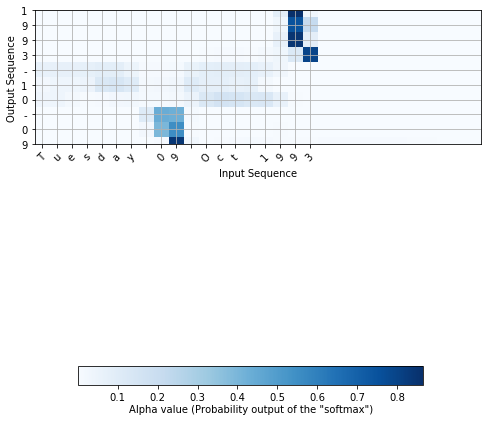

In [17]:
attention_map = plot_attention_map(nmt_model, human_vocab, inv_machine_vocab, "Tuesday 09 Oct 1993", num = 7, n_s = 64)